## Deep CNN learning to differentiate african and asian elephants

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB3

In [3]:
IMG_SIZE = (300,300)
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    validation_split = 0.2,
    rotation_range = 15,
    zoom_range = 0.15,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    "data/train",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "training"
)

val_generator = train_datagen.flow_from_directory(
    "data/train",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    subset = "validation"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_generator = test_datagen.flow_from_directory(
    "data/test",
    target_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = "binary",
    shuffle = False
)



Found 672 images belonging to 2 classes.
Found 168 images belonging to 2 classes.
Found 188 images belonging to 2 classes.


In [4]:
base_model = EfficientNetB3(
    weights = "imagenet",
    include_top = False,
    input_shape = (300, 300, 3)
)

base_model.trainable = False

In [5]:
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(1, activation = "sigmoid")
])

In [6]:
model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

In [7]:
callbacks = [
    EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        restore_best_weights = True
    ),
    ModelCheckpoint(
        "elephant_classifier.keras",
        monitor = "val_loss",
        save_best_only = True
    )
]

In [8]:
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 30,
    callbacks = callbacks
)

base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False
    
model.compile(
    optimizer = Adam(learning_rate = 1e-5),
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
)

history_finetune = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs = 15,
    callbacks = callbacks
)

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 49s 977ms/step - accuracy: 0.5104 - loss: 0.7161 - val_accuracy: 0.4940 - val_loss: 0.6950
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 771ms/step - accuracy: 0.5357 - loss: 0.6944 - val_accuracy: 0.5714 - val_loss: 0.6905
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 740ms/step - accuracy: 0.5714 - loss: 0.6866 - val_accuracy: 0.5536 - val_loss: 0.6757
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 745ms/step - accuracy: 0.5952 - loss: 0.6629 - val_accuracy: 0.6071 - val_loss: 0.6683
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 730ms/step - accuracy: 0.6280 - loss: 0.6660 - val_accuracy: 0.6012 - val_loss: 0.6837
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 743ms/step - accuracy: 0.6161 - loss: 0.6622 - val_accuracy: 0.6369 - val_loss: 0.6535
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 729ms/step - accuracy: 0.6473 - loss: 0.6281 - val_accuracy: 0.6429 - val_loss: 0.6695
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 753ms/step - accuracy: 0.6577 - loss: 0.6314 - val_accu

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 666ms/step - accuracy: 0.9202 - loss: 0.3946
Test Accuracy: 0.920


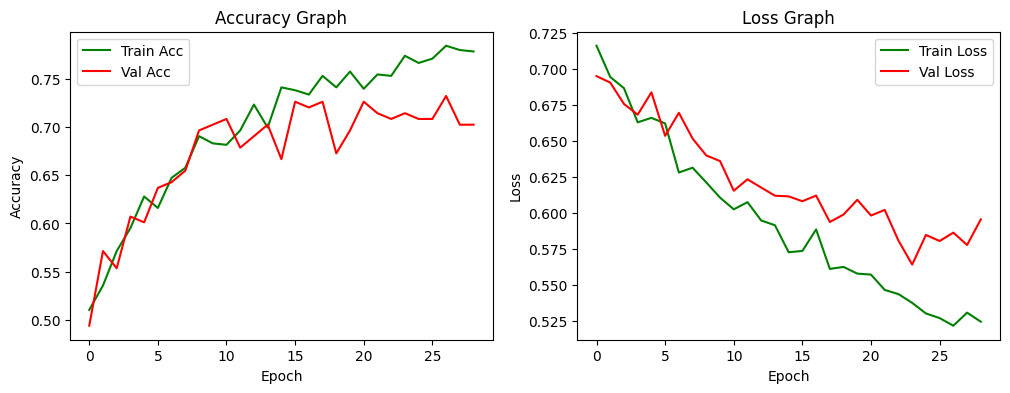

In [10]:
def plot_history(history):
    
    plt.figure(figsize = (12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label = "Train Acc", color = "green")
    plt.plot(history.history["val_accuracy"], label = "Val Acc", color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Graph")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label = "Train Loss", color = "green")
    plt.plot(history.history["val_loss"], label = "Val Loss", color = "red")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Graph")

    plt.show()

plot_history(history)